# Fahrspurerkennung

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from Calibration import Calibration

## 0 Entzerrung

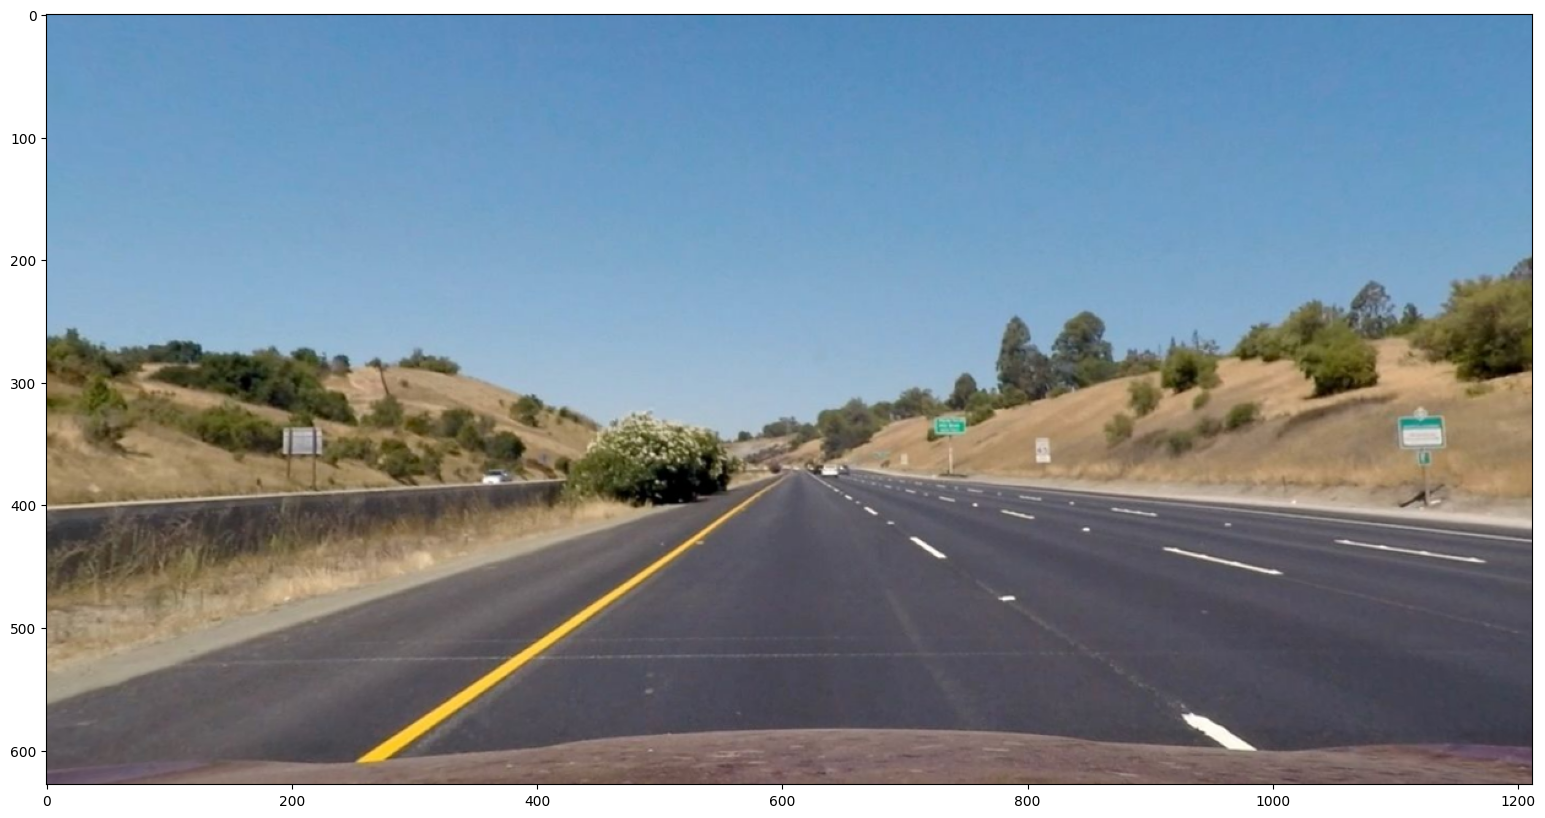

In [3]:
calib = Calibration()
imgs = [cv.imread(f"images/Udacity/image00{i + 1}.jpg", cv.IMREAD_COLOR) for i in range(8)]
img = cv.imread("images/Udacity/image001.jpg", cv.IMREAD_COLOR)
imgs = [cv.cvtColor(im, cv.COLOR_BGR2RGB) for im in imgs]
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
imgs = [calib.undistort(im) for im in imgs]
img = calib.undistort(img)

plt.figure(figsize=(20,10))
plt.imshow(imgs[0])
plt.show()

## 1. Cut out 

8
(205, 900, 3)


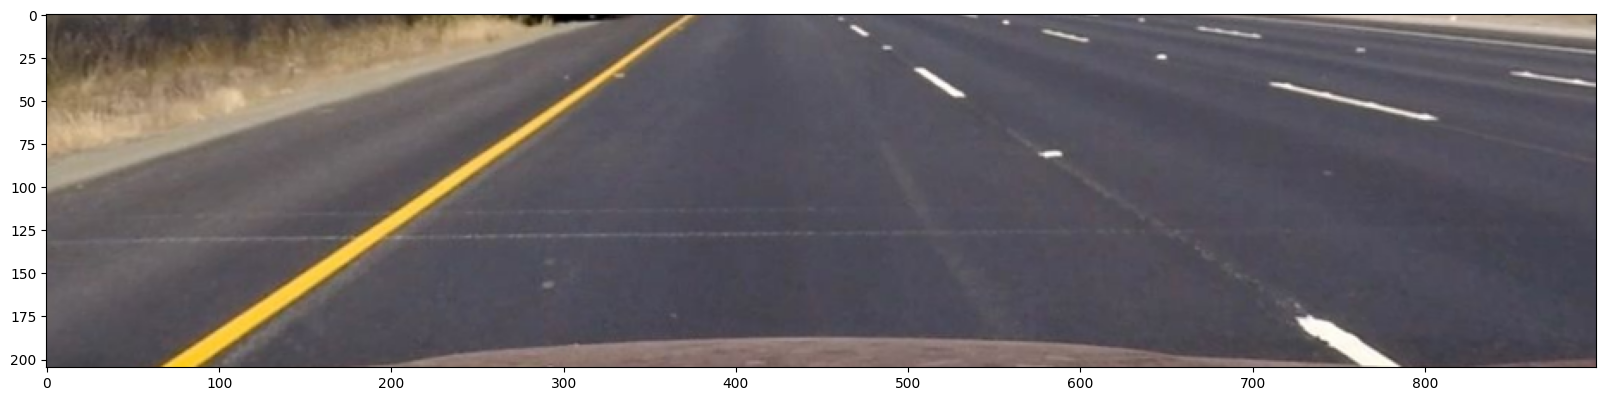

In [4]:
imgs_cut = [im[395: 600, 200: 1100] for im in imgs]
print(len(imgs_cut))
print(imgs_cut[0].shape)
img = imgs_cut[0]

plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

## 1. Gelb → Weiß 

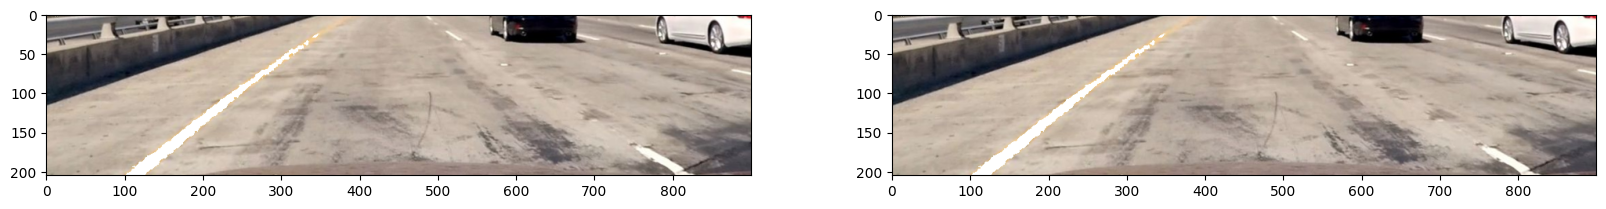

In [5]:

def yellow_to_white(img_to_change):
    img_hsv = cv.cvtColor(img_to_change, cv.COLOR_RGB2HSV)
    yellow_low = (20, 75 , 50)
    yellow_high = (40, 255, 255)
    img_to_change = img_to_change.copy()
    img_yellow = cv.inRange(img_hsv, yellow_low, yellow_high)
    img_to_change[np.where(img_yellow > 0)] = (255, 255, 255)
    return img_to_change

# yellow_low = (20, 75 , 75)
# yellow_high = (40, 255, 255)
# img_yellow = cv.inRange(img, yellow_low, yellow_high)
img_y = yellow_to_white(img)
imgs_y = [yellow_to_white(im) for im in imgs_cut]
# img_f[np.where(img_yellow > 0)] = (0, 0, 180)
# img_f = cv.cvtColor(img_f, cv.COLOR_HSV2RGB)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(imgs_y[2])
plt.subplot(1,2,2)
plt.imshow(imgs_y[2])

## 2. Grauwertbild

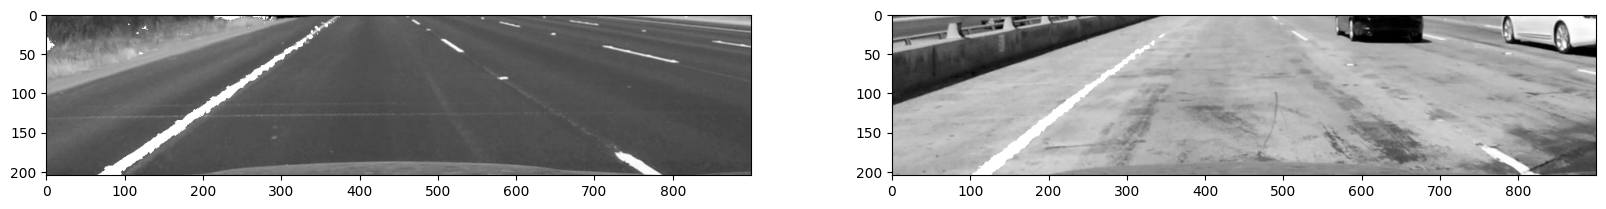

In [6]:
img_gray = cv.cvtColor(img_y, cv.COLOR_RGB2GRAY)
imgs_gray = [cv.cvtColor(im, cv.COLOR_RGB2GRAY) for im in imgs_y]
# imgs_gray = [cv.equalizeHist(im) for im in imgs_gray]
# imgs_gray = [cv.adaptiveThreshold(im, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 2) for im in imgs_gray]
# for k, im in enumerate(imgs_gray):
#     cv.imshow(f'image {k + 1}', im)
#     cv.waitKey(0)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgs_gray[2], cmap='gray')
plt.show()

## 3. Kantenerkennung mit canny edge

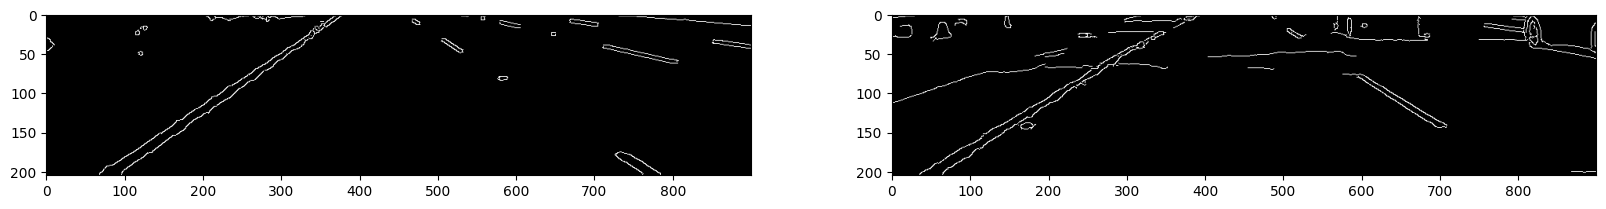

In [7]:
def gauss_and_canny(img_to_canny):
    img_blurred = cv.GaussianBlur(img_to_canny.copy(), (5,5), cv.BORDER_DEFAULT)
    return cv.Canny(img_blurred, 73, 145)

img_canny = gauss_and_canny(img_gray)
imgs_canny = [gauss_and_canny(im) for im in imgs_gray]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_canny, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgs_canny[6], cmap='gray')
plt.show()
# 
# for k, im in enumerate(imgs_canny):
#     cv.imshow(f'image {k + 1}', im)
#     cv.waitKey(0)

# ROI 

In [24]:
print(img.shape)
# 4 roi points in clockwise order starting from top left
src = np.float32([[300, 50],  [25, 225], [850, 225] , [550, 10]])
mid_roi = np.float32([[300, 125], [150, 225], [675, 225], [550, 125]])
img_test = cv.imread("images/Udacity/image001.jpg", cv.IMREAD_COLOR)
img_test = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_test = calib.undistort(img_test)
img_test = img_test[375: 600, 200: 1100]
# function for roi with src
def black_out_except_roi(img_for_cutting,roi):
    middle_x = img_for_cutting.shape[1] / 2
    middle_y = img_for_cutting.shape[0] / 2
    triangle_top_l = (middle_y + 50, middle_x - img_for_cutting.shape[1] / 20)
    triangle_top_r = (middle_y + 50, middle_x + img_for_cutting.shape[1] / 20)
    triangle_left = (img_for_cutting.shape[0], img.shape[1] / 10)
    triangle_right = (img_for_cutting.shape[0], img.shape[1] * 9 / 10)
    vertices = np.array([[triangle_left, triangle_top_l, triangle_top_r, triangle_right]], dtype=np.int32)
    mask = np.zeros_like(img_for_cutting)
    cv.fillPoly(mask, vertices, (255, 255, 255))
    # mask = np.zeros_like(img_for_cutting)
    # cv.fillPoly(mask, np.int32([roi]), (255, 255, 255))
    #cv.fillPoly(mask, np.int32([mid_roi]), (255, 255, 255))
    return cv.bitwise_and(img_for_cutting, mask)

def black_out_region(img_for_cutting, region):
    return cv.fillPoly(img_for_cutting, np.int32([region]), (0, 0, 0))
#
# cutting all images
imgs_roi = [black_out_except_roi(im,src) for im in imgs_canny]
# imgs_roi = [black_out_region(im, mid_roi) for im in imgs_roi]
img_roi = imgs_roi[2]




(205, 900)


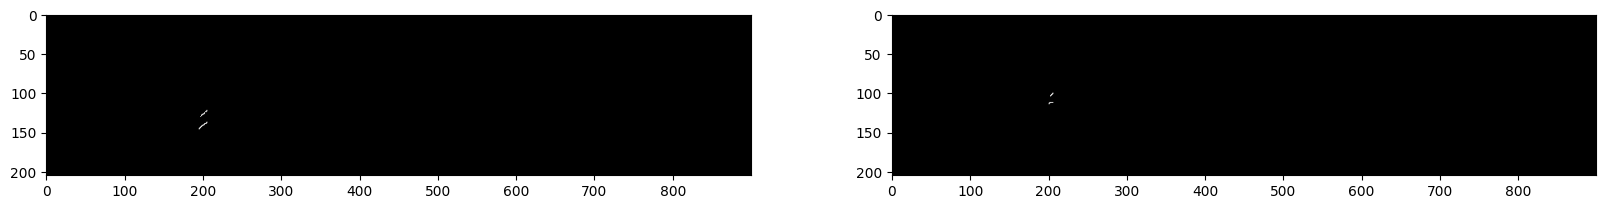

In [25]:
plt.figure(figsize=(20,10))
# display two images in a subplot
plt.subplot(1,2,1)
plt.imshow(img_roi, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgs_roi[6], cmap='gray')
img = img_roi


## 3.5 Waagerechte Linien Entfernen

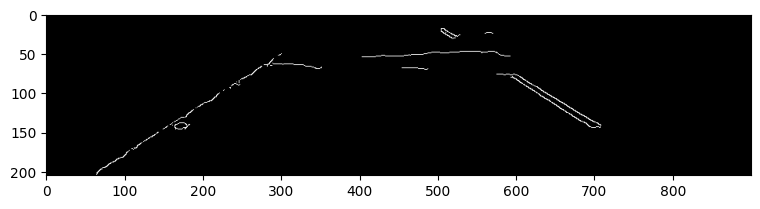

In [10]:
def remove_horizontal_lines(img_to_remove):
    img_to_remove = img_to_remove.copy()
    horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (10,1))
    horizontal_lines = cv.morphologyEx(img_to_remove, cv.MORPH_OPEN, horizontal_kernel, iterations=3)
    img_to_remove = cv.subtract(img_to_remove, horizontal_lines)
    return img_to_remove

imgs_no_hor = [remove_horizontal_lines(im) for im in imgs_roi]
img_no_hor = imgs_no_hor[6]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_no_hor, cmap='gray')

## 4. Transformation in Birds-Eye-View

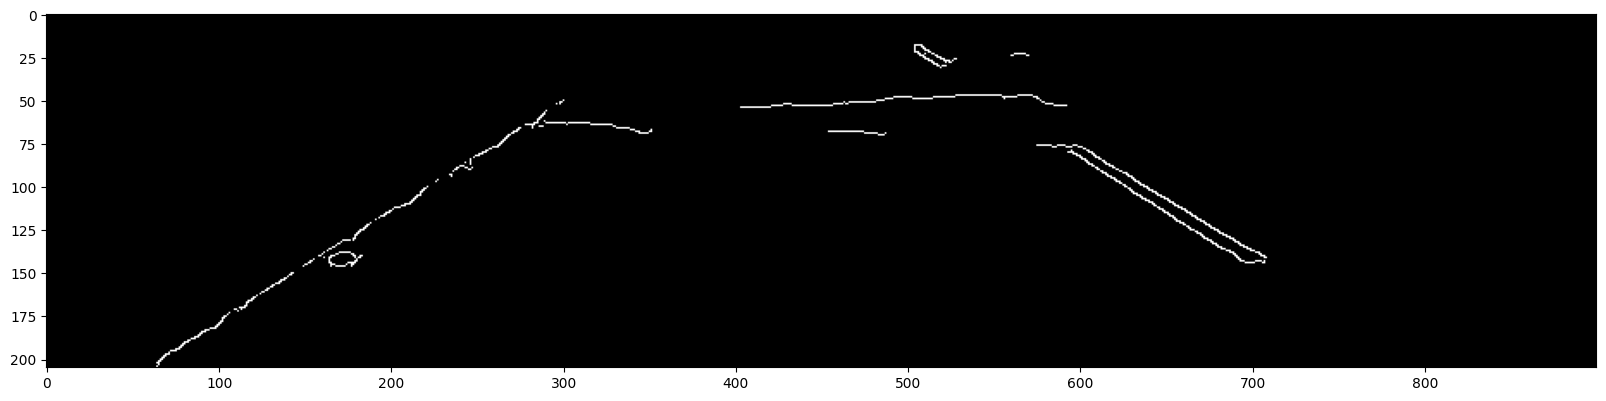

In [11]:
# imgs_birdseye = [calib.warp_to_birdseye(im) for im in imgs_canny]
# img_birdseye = calib.warp_to_birdseye(img_canny)

#imgs_closed = [cv.morphologyEx(im, cv.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=4) for im in imgs_no_hor]
#imgs_eroded = [cv.morphologyEx(im, cv.MORPH_OPEN, np.ones((2,2), np.uint8), iterations=3) for im in imgs_closed]
imgs_eroded = [im.copy() for im in imgs_roi]
#img_closed = cv.morphologyEx(img_canny, cv.MORPH_CLOSE, np.ones((5,5), np.uint8), iterations=10)
#imgs_closed = [im.copy() for im in imgs_roi]
plt.figure(figsize=(20,10))
plt.imshow(imgs_eroded[6], cmap='gray')
plt.show()

## 4. Hough-Transformation

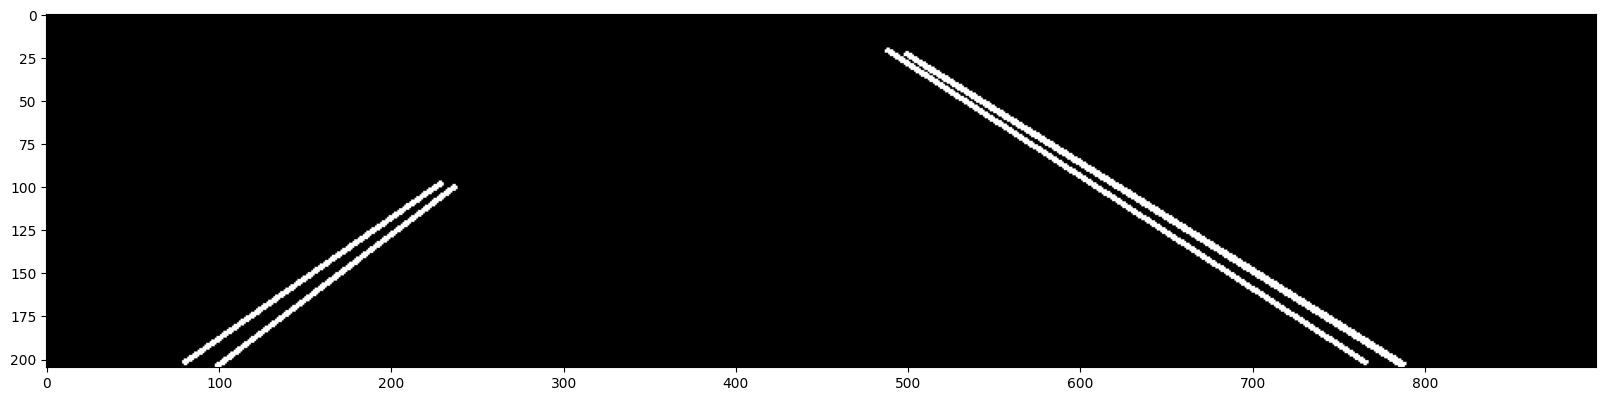

In [16]:
lines = cv.HoughLinesP(imgs_eroded[1], rho=2, theta=np.pi/180, threshold=100, minLineLength=100, maxLineGap=50, lines=np.array([]))
img_hough = imgs_eroded[4].copy()

blank_img = np.zeros_like(img_hough)

x_acc_l = []
y_acc_l = []
x_acc_r = []
y_acc_r = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    x_acc_l.append(x1) if x1 < 400 and x2 < 400 else None
    x_acc_l.append(x2) if x1 < 400 and x2 < 400 else None
    y_acc_l.append(y1) if x1 < 400 and x2 < 400 else None
    y_acc_l.append(y2) if x1 < 400 and x2 < 400 else None
    x_acc_r.append(x1) if 400 < x1 and 400 < x2 else None
    x_acc_r.append(x2) if 400 < x1 and 400 < x2 else None
    y_acc_r.append(y1) if 400 < x1 and 400 < x2 else None
    y_acc_r.append(y2) if 400 < x1 and 400 < x2 else None
    cv.line(blank_img, (x1, y1), (x2, y2), (255, 255, 255), 2)

x_acc_r = np.array(x_acc_r).sort()
y_acc_r = np.array(y_acc_r).sort()
x_acc_l = np.array(x_acc_l).sort()
y_acc_l = np.array(y_acc_l).sort()
# blank_img = cv.morphologyEx(blank_img, cv.MORPH_ERODE, np.ones((2,2), np.uint8), iterations=3)
plt.figure(figsize=(20,10))
plt.imshow(blank_img, cmap='gray')
plt.show()

In [19]:
w2_2, w2_1, w2_0 = np.polynomial.polynomial.polyfit(x_acc_r, y_acc_l, 2)
w1_2, w1_1, w1_0 = np.polynomial.polynomial.polyfit(x_acc_r, y_acc_r, 2)

wrl_1, wrl_0 = np.polynomial.polynomial.polyfit(y_acc_r, x_acc_r, 1)
wll_1, wll_0 = np.polynomial.polynomial.polyfit(y_acc_l, x_acc_l, 1)

x= np.linspace(0, 1000, 500)
y_l = w2_2 * x ** 2 + w2_1 * x + w2_0
y_r = w1_2 * x ** 2 + w1_1 * x + w1_0
#y_l = wll_1 * x + wll_0
#y_r = wrl_1 * x + wrl_0

#min_ind = np.searchsorted(y_l, 0)
#max_ind = np.searchsorted(y_l, 200)
#l_ind = min(min_ind, max_ind)
#r_ind = max(min_ind, max_ind)

#y_l = y_l[l_ind:r_ind]
#x = x[l_ind:r_ind]
x_r = x[y_r > 0]
y_r = y_r[y_r > 0]
x_l = x[y_l > 0]
y_l = y_l[y_l > 0]

x_r = x_r[y_r < 205]
y_r = y_r[y_r < 205]
x_l = x_l[y_l < 205]
y_l = y_l[y_l < 205]

plt.figure(figsize=(20,10))
plt.imshow(blank_img, cmap='gray')
plt.plot(x_l, y_l, color='red')
plt.plot(x_r, y_r, color='red')
plt.show()

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'